In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [13]:
# Read X_train.csv, X_test.csv, y_train.csv, y_test.csv
X_train = pd.read_csv('Data2/X_train.csv')
X_test = pd.read_csv('Data2/X_test.csv')
y_train = pd.read_csv('Data2/y_train.csv')
y_test = pd.read_csv('Data2/y_test.csv')

In [14]:
# check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((96, 29), (42, 29), (96, 1), (42, 1))

In [15]:
from sklearn.metrics import make_scorer, fbeta_score

f2_scorer = make_scorer(fbeta_score, beta=2) # we care recall more than precision

### Decision Tree Classifier

In [16]:
# define a optuna objective function for decision tree classifier
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def dt_objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 12),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': 66
    }
    dt = DecisionTreeClassifier(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        dt.fit(X_train_op, y_train_op)
        score = accuracy_score(y_test_op, dt.predict(X_test_op))
        # score = f2_scorer(dt, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

In [17]:
def early_stopping_check(study, trial, early_stopping_rounds=20): # default is to stop study if there are 20 trials without improvement
    current_trial_number = trial.number
    best_trial_number = study.best_trial.number
    should_stop = (current_trial_number - best_trial_number) >= early_stopping_rounds
    if should_stop:
        study.stop()

In [18]:
# run the optimization
from functools import partial

study_dt = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='DecisionTree')
study_dt.optimize(dt_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

[I 2024-03-02 20:17:33,152] A new study created in memory with name: DecisionTree
[I 2024-03-02 20:17:33,165] Trial 0 finished with value: 0.6979166666666666 and parameters: {'max_depth': 4, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6979166666666666.
[I 2024-03-02 20:17:33,176] Trial 1 finished with value: 0.6979166666666666 and parameters: {'max_depth': 10, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 0 with value: 0.6979166666666666.
[I 2024-03-02 20:17:33,187] Trial 2 finished with value: 0.6875 and parameters: {'max_depth': 10, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6979166666666666.
[I 2024-03-02 20:17:33,197] Trial 3 finished with value: 0.6875 and parameters: {'max_depth': 3, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6979166666666666.
[I 2024-03-02 20:17:33,207] Trial 4 finished with value: 0.71875 and parameters: {'max_depth': 10, 'min_samples_leaf': 8, '

In [19]:
# Best hyperparameters
print('Best hyperparameters:', study_dt.best_params)

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 8, 'criterion': 'gini'}


## Result

In [20]:
# evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

dt = DecisionTreeClassifier(**study_dt.best_params)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.74      0.60        19
           1       0.64      0.39      0.49        23

    accuracy                           0.55        42
   macro avg       0.57      0.56      0.54        42
weighted avg       0.58      0.55      0.54        42

[[14  5]
 [14  9]]


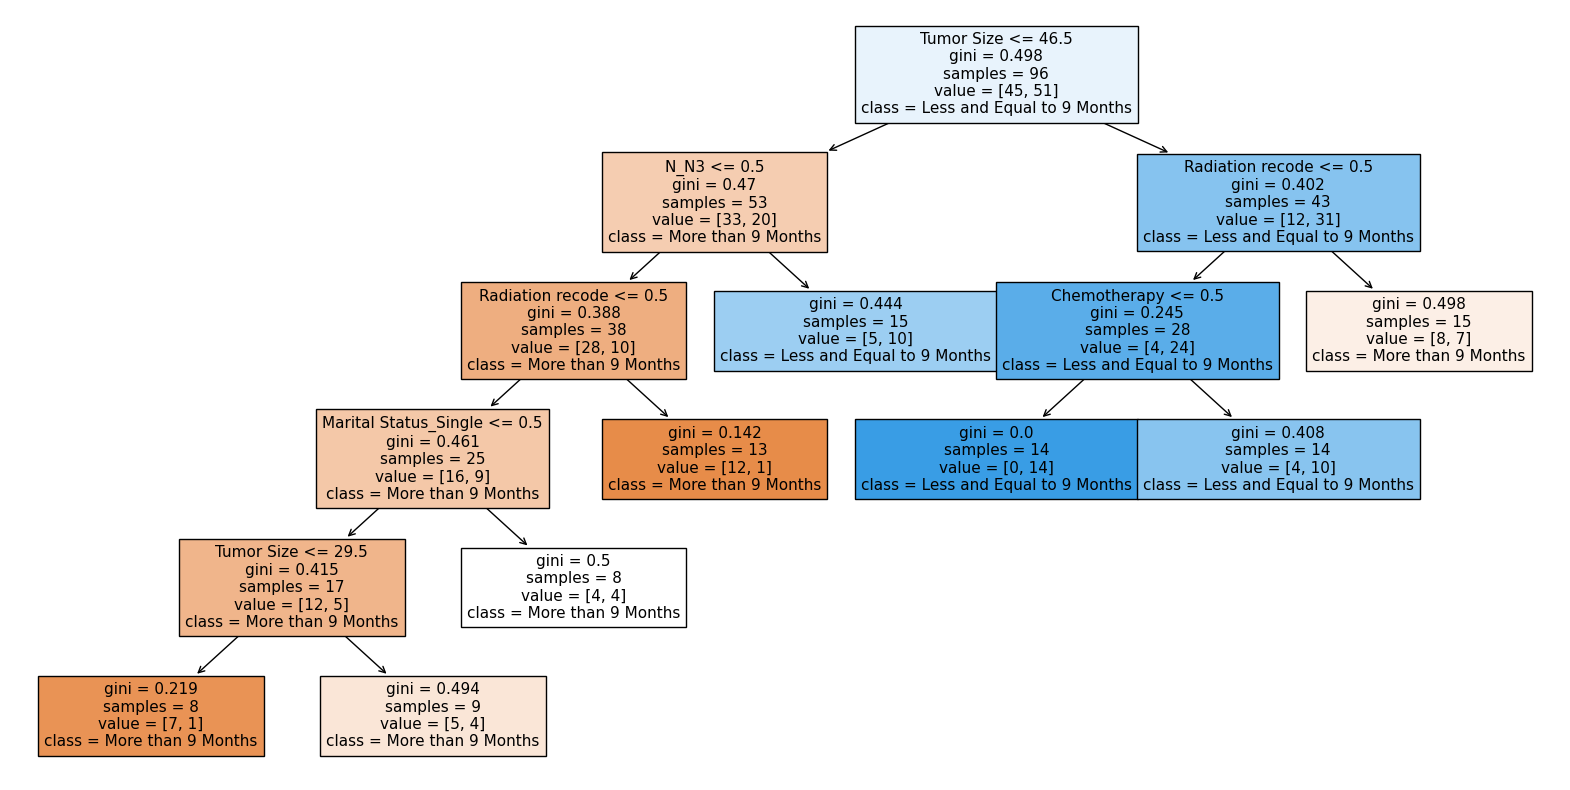

In [21]:
# visualize the tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=X_train.columns, class_names=['More than 9 Months','Less and Equal to 9 Months'])
plt.show()

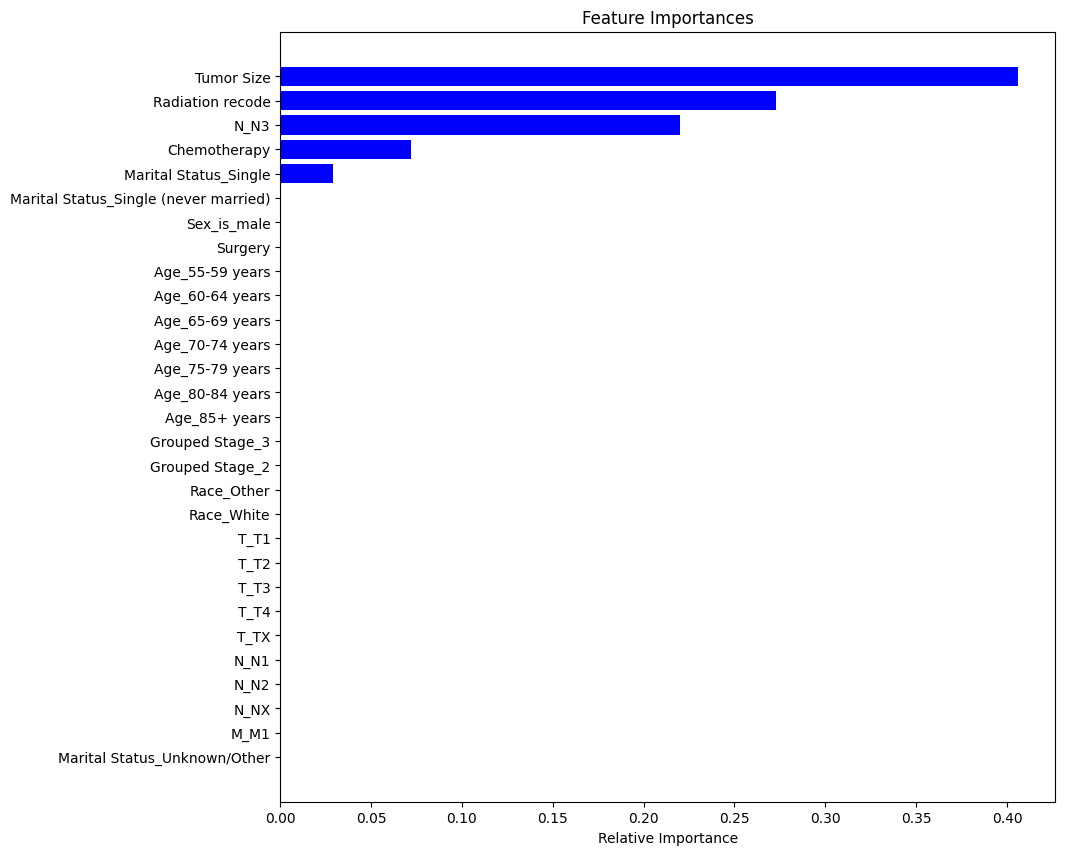

In [22]:
# plot feature importance
importances = dt.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Random Forest Classifier

In [23]:
from sklearn.preprocessing import StandardScaler
# Fit the scaler to the "Tumor Size" column in the training data
scaler = StandardScaler()
scaler.fit(X_train[["Tumor Size"]])
X_train["Tumor Size"] = scaler.transform(X_train[["Tumor Size"]])
X_test["Tumor Size"] = scaler.transform(X_test[["Tumor Size"]])

In [24]:
# define a optuna objective function for random forest classifier
from sklearn.ensemble import RandomForestClassifier

def rf_objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),  
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # Limit depth to prevent overfitting
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 12),  
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),  
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),  
        'random_state': 66  
    }
    rf = RandomForestClassifier(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        y_train_op = y_train_op.squeeze()
        rf.fit(X_train_op, y_train_op)
        score = accuracy_score(y_test_op, rf.predict(X_test_op))
        # score = f2_scorer(rf, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

In [25]:
# run the optimization
study_rf = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='RandomForest')
study_rf.optimize(rf_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

[I 2024-03-02 20:17:42,102] A new study created in memory with name: RandomForest
[I 2024-03-02 20:17:42,322] Trial 0 finished with value: 0.7083333333333334 and parameters: {'n_estimators': 121, 'max_depth': 4, 'min_samples_leaf': 11, 'min_samples_split': 9, 'criterion': 'gini'}. Best is trial 0 with value: 0.7083333333333334.
[I 2024-03-02 20:17:42,786] Trial 1 finished with value: 0.7291666666666666 and parameters: {'n_estimators': 270, 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 5, 'criterion': 'gini'}. Best is trial 1 with value: 0.7291666666666666.
[I 2024-03-02 20:17:43,202] Trial 2 finished with value: 0.7083333333333334 and parameters: {'n_estimators': 253, 'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 7, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7291666666666666.
[I 2024-03-02 20:17:43,383] Trial 3 finished with value: 0.7083333333333334 and parameters: {'n_estimators': 103, 'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split

In [26]:
# Best hyperparameters
print('Best hyperparameters:', study_rf.best_params)

Best hyperparameters: {'n_estimators': 219, 'max_depth': 9, 'min_samples_leaf': 11, 'min_samples_split': 10, 'criterion': 'gini'}


## Result

In [27]:
# evaluate the model
rf = RandomForestClassifier(**study_rf.best_params)
rf.fit(X_train, y_train.squeeze())
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.42      0.50        19
           1       0.62      0.78      0.69        23

    accuracy                           0.62        42
   macro avg       0.62      0.60      0.60        42
weighted avg       0.62      0.62      0.61        42

[[ 8 11]
 [ 5 18]]


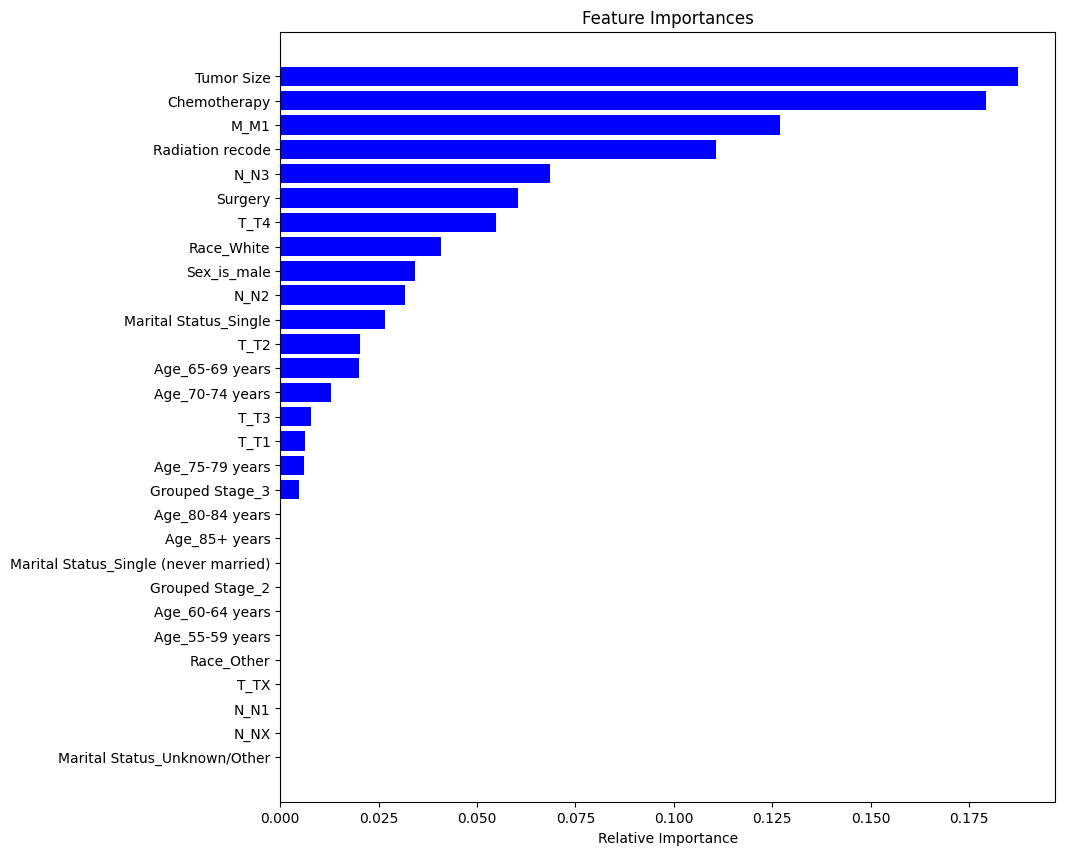

In [28]:
# plot feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## SVM

In [29]:
# define a optuna objective function for SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def svm_objective(trial):
    param = {
        'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'degree': trial.suggest_int('degree', 2, 5),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'random_state': 66
    }
    svm = SVC(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        y_train_op = y_train_op.squeeze()
        svm.fit(X_train_op, y_train_op)
        score = accuracy_score(y_test_op, svm.predict(X_test_op))
        # score = f2_scorer(svm, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

In [30]:
# run the optimization
study_svm = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='SVM')
study_svm.optimize(svm_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

[I 2024-03-02 20:18:09,066] A new study created in memory with name: SVM
[I 2024-03-02 20:18:09,078] Trial 0 finished with value: 0.7395833333333334 and parameters: {'C': 10.597364053319012, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto'}. Best is trial 0 with value: 0.7395833333333334.
[I 2024-03-02 20:18:09,089] Trial 1 finished with value: 0.7395833333333334 and parameters: {'C': 1.80293108582682, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale'}. Best is trial 0 with value: 0.7395833333333334.
[I 2024-03-02 20:18:09,136] Trial 2 finished with value: 0.625 and parameters: {'C': 714.8708301324587, 'kernel': 'linear', 'degree': 3, 'gamma': 'scale'}. Best is trial 0 with value: 0.7395833333333334.
[I 2024-03-02 20:18:09,145] Trial 3 finished with value: 0.7708333333333334 and parameters: {'C': 0.47160253550622255, 'kernel': 'linear', 'degree': 3, 'gamma': 'auto'}. Best is trial 3 with value: 0.7708333333333334.
[I 2024-03-02 20:18:09,159] Trial 4 finished with value: 0.7291666666666666 an

In [31]:
# Best hyperparameters
print('Best hyperparameters:', study_svm.best_params)

Best hyperparameters: {'C': 136.7846795837732, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'auto'}


## Result

In [32]:
# evaluate the model
svm = SVC(**study_svm.best_params)
svm.fit(X_train, y_train.squeeze())
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.53      0.61        19
           1       0.68      0.83      0.75        23

    accuracy                           0.69        42
   macro avg       0.70      0.68      0.68        42
weighted avg       0.69      0.69      0.68        42

[[10  9]
 [ 4 19]]


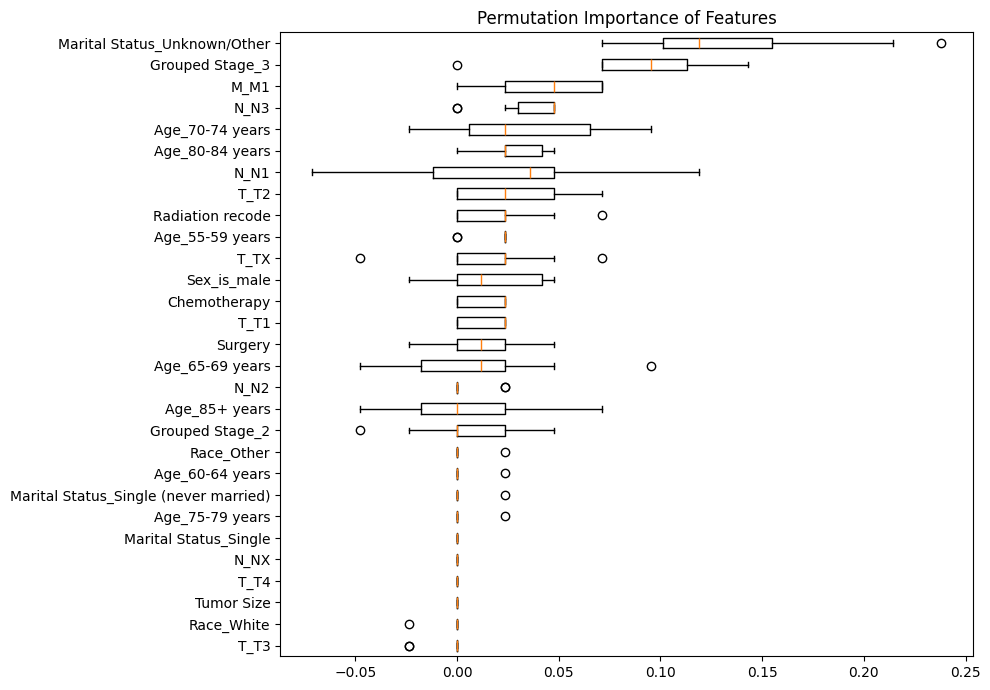

In [33]:
# plot feature importance
from sklearn.inspection import permutation_importance
result = permutation_importance(svm, X_test, y_test, n_repeats=10, random_state=66, n_jobs=-1)

# Get the importances and their standard deviations
importances = result.importances_mean
stds = result.importances_std

feature_names = [X_train.columns[i] for i in result.importances_mean.argsort()]

# Sort the features by importance
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 7))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()

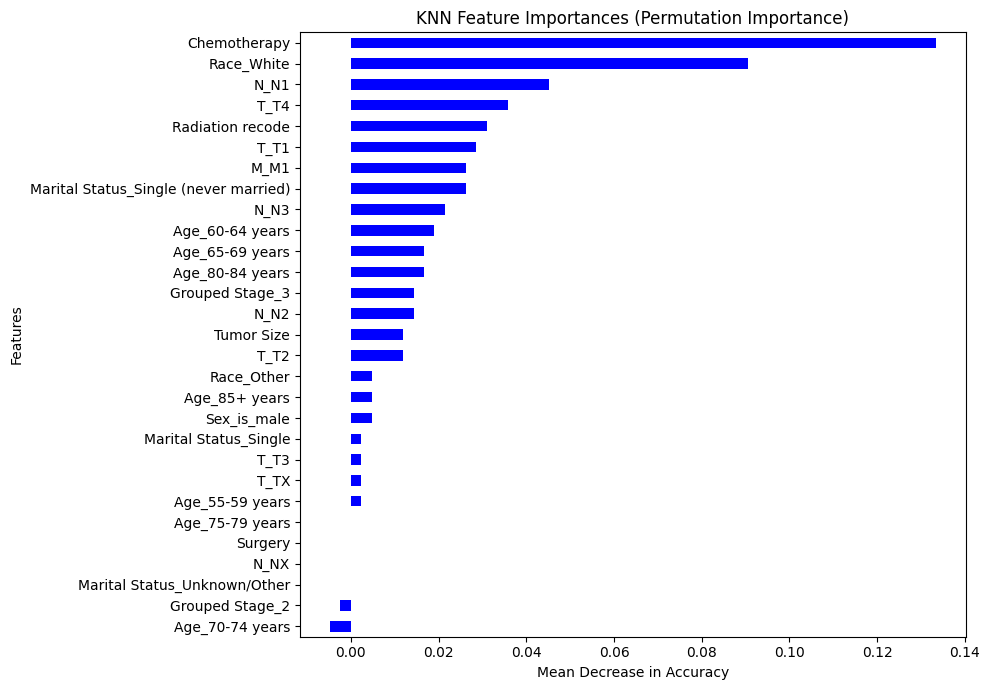

In [34]:
result = permutation_importance(svm, X_test, y_test, n_repeats=10, random_state=66, n_jobs=-1)

# Convert importances into a pandas Series for easier plotting, with feature names as the index
feature_importances_knn = pd.Series(data=result.importances_mean, index=X_train.columns)

# Sorting the importances for visualization
importances_sorted_knn = feature_importances_knn.sort_values()

# Plotting KNN feature importances
plt.figure(figsize=(10, 7))
importances_sorted_knn.plot(kind='barh', color='blue')
plt.title('KNN Feature Importances (Permutation Importance)')
plt.xlabel('Mean Decrease in Accuracy')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## KNN

In [35]:
# define a optuna objective function for KNN
from sklearn.neighbors import KNeighborsClassifier

def knn_objective(trial):
    param = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 20),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'p': trial.suggest_int('p', 1, 2),
    }
    knn = KNeighborsClassifier(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        y_train_op = y_train_op.squeeze()
        knn.fit(X_train_op, y_train_op)
        score = accuracy_score(y_test_op, knn.predict(X_test_op))
        score = f2_scorer(knn, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

In [36]:
# run the optimization
study_knn = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='KNN')
study_knn.optimize(knn_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

[I 2024-03-02 20:18:29,711] A new study created in memory with name: KNN
[I 2024-03-02 20:18:29,738] Trial 0 finished with value: 0.6944444444444443 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 2}. Best is trial 0 with value: 0.6944444444444443.
[I 2024-03-02 20:18:29,764] Trial 1 finished with value: 0.6742724867724869 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 1}. Best is trial 0 with value: 0.6944444444444443.
[I 2024-03-02 20:18:29,791] Trial 2 finished with value: 0.8280685632602008 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 2}. Best is trial 2 with value: 0.8280685632602008.
[I 2024-03-02 20:18:30,016] Trial 3 finished with value: 0.7696277920997021 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'auto', 'p': 2}. Best is trial 2 with value: 0.8280685632602008.
[I 2024-03-02 20:18:30,039] Trial 4 finished with value: 0.8123321076095

In [37]:
# Best hyperparameters
print('Best hyperparameters:', study_knn.best_params)


Best hyperparameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 2}


## Result

In [38]:
# evaluate the model
knn = KNeighborsClassifier(**study_knn.best_params)
knn.fit(X_train, y_train.squeeze())
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.47      0.49        19
           1       0.58      0.61      0.60        23

    accuracy                           0.55        42
   macro avg       0.54      0.54      0.54        42
weighted avg       0.55      0.55      0.55        42

[[ 9 10]
 [ 9 14]]


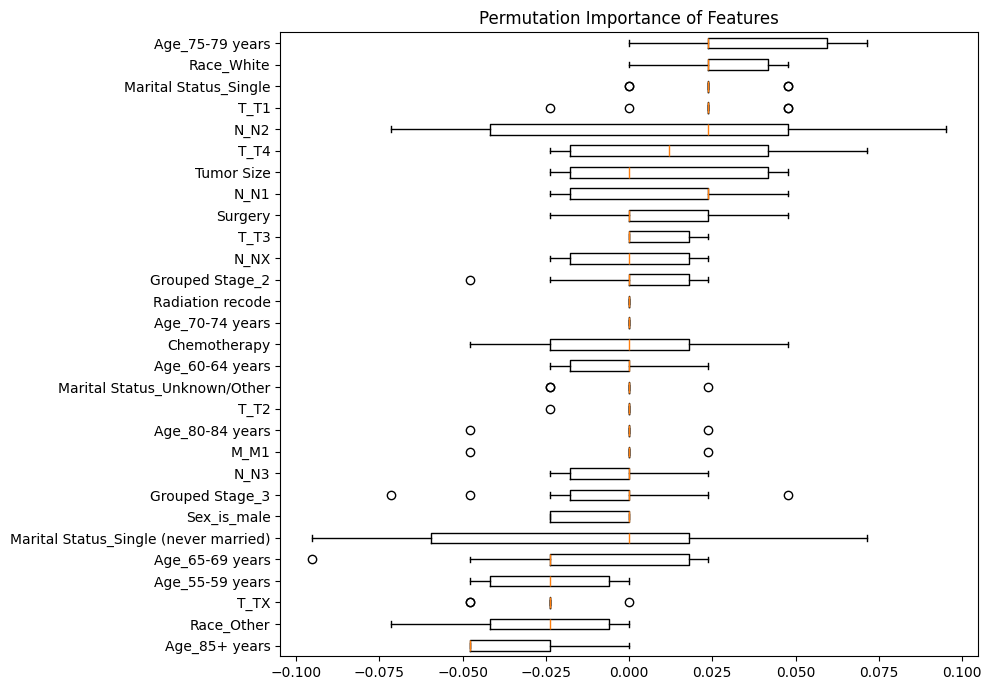

In [39]:
# plot feature importance for KNN
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=66, n_jobs=-1)

# Get the importances and their standard deviations
importances = result.importances_mean
stds = result.importances_std

feature_names = [X_train.columns[i] for i in result.importances_mean.argsort()]

# Sort the features by importance
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 7))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()



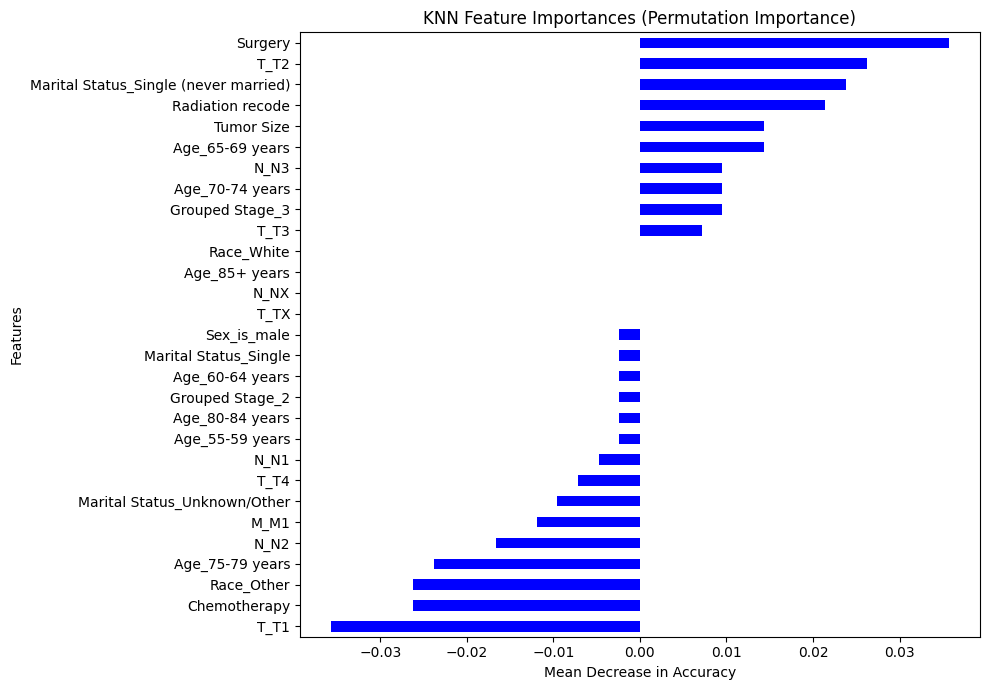

In [40]:
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=66, n_jobs=-1)

# Convert importances into a pandas Series for easier plotting, with feature names as the index
feature_importances_knn = pd.Series(data=result.importances_mean, index=X_train.columns)

# Sorting the importances for visualization
importances_sorted_knn = feature_importances_knn.sort_values()

# Plotting KNN feature importances
plt.figure(figsize=(10, 7))
importances_sorted_knn.plot(kind='barh', color='blue')
plt.title('KNN Feature Importances (Permutation Importance)')
plt.xlabel('Mean Decrease in Accuracy')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## Logistic Regression

In [41]:
# define a optuna objective function for logistic regression
from sklearn.linear_model import LogisticRegression

def lr_objective(trial):
    param = {
        'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'random_state': 66
    }
    lr = LogisticRegression(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        y_train_op = y_train_op.squeeze()
        lr.fit(X_train_op, y_train_op)
        score = accuracy_score(y_test_op, lr.predict(X_test_op))
        # score = f2_scorer(lr, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

In [42]:
# run the optimization
study_lr = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='LogisticRegression')
study_lr.optimize(lr_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

[I 2024-03-02 20:18:53,418] A new study created in memory with name: LogisticRegression
[I 2024-03-02 20:18:53,430] Trial 0 finished with value: 0.6979166666666666 and parameters: {'C': 4.206641086460418, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.6979166666666666.
c:\Users\yuyum\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\yuyum\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\yuyum\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-03-02 20:18:53,447] Trial 1 finished with value: 0.6875 and parameters: {'

In [43]:
# Best hyperparameters
print('Best hyperparameters:', study_lr.best_params)

Best hyperparameters: {'C': 0.20856179532644462, 'penalty': 'l2', 'solver': 'saga'}


## Result

In [44]:
# evaluate the model
lr = LogisticRegression(**study_lr.best_params)
lr.fit(X_train, y_train.squeeze())
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53        19
           1       0.61      0.61      0.61        23

    accuracy                           0.57        42
   macro avg       0.57      0.57      0.57        42
weighted avg       0.57      0.57      0.57        42

[[10  9]
 [ 9 14]]


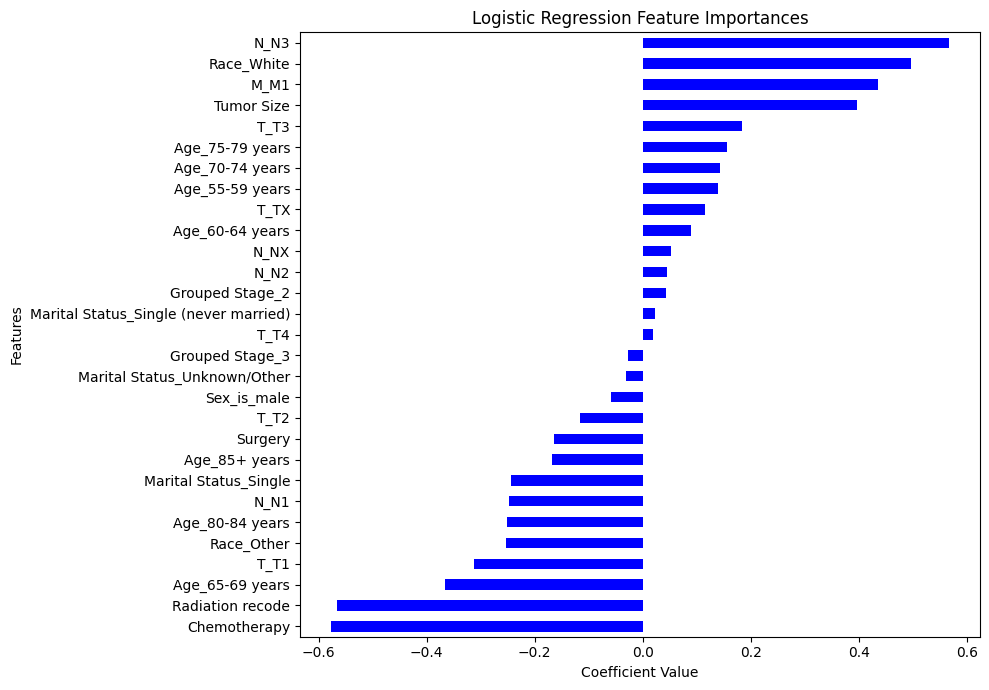

In [45]:
# Plot the feature importances
feature_importances_lr = pd.Series(data=lr.coef_[0], index=X_train.columns)

# Sorting the coefficients for visualization
importances_sorted_lr = feature_importances_lr.sort_values()

# Plotting logistic regression feature importances
plt.figure(figsize=(10, 7))
importances_sorted_lr.plot(kind='barh', color='blue')
plt.title('Logistic Regression Feature Importances')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## LightGBM

In [46]:
from optuna.integration.lightgbm import LightGBMTunerCV as lgbtcv
import lightgbm as lgb
from lightgbm import early_stopping
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [47]:
def lgb_objective(trial):
    param = {
        'objective': 'binary',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 10),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 20),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'random_state': 66
    }
    lgbm = lgb.LGBMClassifier(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        y_train_op = y_train_op.squeeze()
        lgbm.fit(X_train_op, y_train_op)
        score = accuracy_score(y_test_op, lgbm.predict(X_test_op))
        # score = f2_scorer(lr, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)


In [48]:
# run the optimization
study_lgb = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='LightGBM')
study_lgb.optimize(lgb_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

In [55]:
# Best hyperparameters
print('Best hyperparameters:', study_lgb.best_params)

# evaluate the model
lgbm = lgb.LGBMClassifier(**study_lgb.best_params)
lgbm.fit(X_train, y_train.squeeze())
y_pred = lgbm.predict(X_test)


Best hyperparameters: {'num_leaves': 11, 'max_depth': 3, 'min_data_in_leaf': 8, 'feature_fraction': 0.867110336101317, 'bagging_fraction': 0.9821133360040286, 'bagging_freq': 3, 'min_child_samples': 4, 'lambda_l1': 1.3187704985189433e-06, 'lambda_l2': 0.00015903144814603047}
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.867110336101317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.867110336101317
[LightGBM] [Warning] lambda_l1 is set=1.3187704985189433e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3187704985189433e-06
[LightGBM] [Warning] lambda_l2 is set=0.00015903144814603047, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015903144814603047
[LightGBM] [Warning] bagging_fraction is set=0.9821133360040286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9821133360040286
[LightGBM] [Warning] ba

## Result

In [60]:
# evaluate the model and print the classification report
# predict the test set
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.63      0.62        19
           1       0.68      0.65      0.67        23

    accuracy                           0.64        42
   macro avg       0.64      0.64      0.64        42
weighted avg       0.64      0.64      0.64        42

[[12  7]
 [ 8 15]]


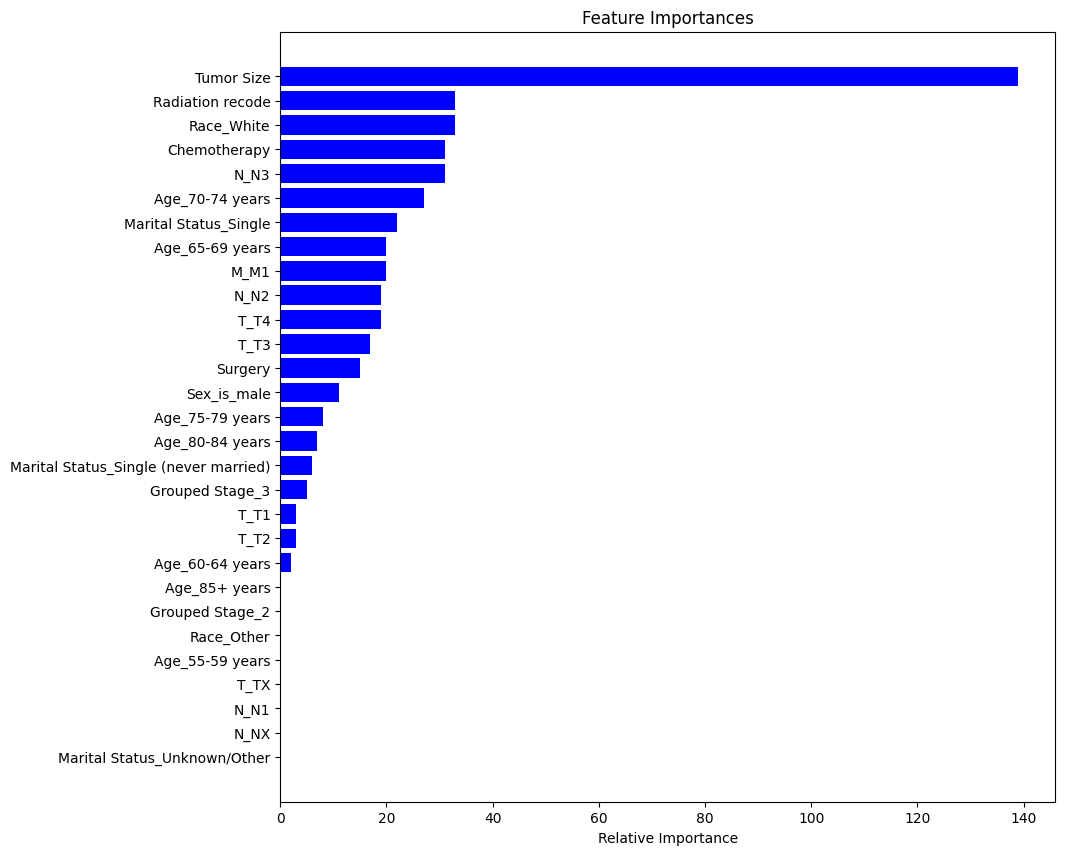

In [62]:
# plot feature importance
importances = lgbm .feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Neural Network

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim

In [64]:
# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 16)  # Hidden layer with 16 neurons
        self.dropout = nn.Dropout(0.5)          # Dropout layer for regularization
        self.layer2 = nn.Linear(16, 8)          # Hidden layer with 8 neurons
        self.layer3 = nn.Linear(8, 1)           # Output layer for binary classification

    def forward(self, x):
        x = torch.relu(self.layer1(x))  # Activation function for hidden layer
        x = self.dropout(x)             # Apply dropout
        x = torch.relu(self.layer2(x))  # Activation function for hidden layer
        x = torch.sigmoid(self.layer3(x))  # Sigmoid activation function for output layer
        return x


In [65]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Reshape y to be 2D
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)



In [68]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 2  

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [69]:
from torch.optim import lr_scheduler
input_size = X_train.shape[1]
model = SimpleNN(input_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
# Optimizer with a starting learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=5, verbose=True)
num_epochs = 3000
patience = 15

In [70]:
device = 'cpu'

In [71]:
import copy

best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())  # To store the best model weights
counter_early_stopping = 0  # Counter for early stopping
train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        # Forward pass
        predictions = model(data)
        # Calculate loss
        loss = criterion(predictions, target)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average loss over the epoch
    avg_train_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # Evaluate the model
    model.eval()  # Set model to evaluate mode
    total_test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            predictions = model(data)
            loss = criterion(predictions, target)
            total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_loss_history.append(avg_test_loss)

    # Print training and test loss
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

    # Check for early stopping
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Epoch {epoch+1} has the best Test Loss: {avg_test_loss}')
        counter_early_stopping = 0
        # Save the best model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, 'best_model_checkpoint.pth')
    else:
        counter_early_stopping += 1
        if counter_early_stopping >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break

    # Update the learning rate
    scheduler.step(avg_test_loss)

# Load the best model weights
model.load_state_dict(best_model_wts)


Epoch 1/3000, Training Loss: 0.6965608149766922, Test Loss: 0.6874045048441205
Epoch 1 has the best Test Loss: 0.6874045048441205
Epoch 2/3000, Training Loss: 0.6921575628221035, Test Loss: 0.6870660753477187
Epoch 2 has the best Test Loss: 0.6870660753477187
Epoch 3/3000, Training Loss: 0.6916757834454378, Test Loss: 0.6870229982194447
Epoch 3 has the best Test Loss: 0.6870229982194447
Epoch 4/3000, Training Loss: 0.6894683837890625, Test Loss: 0.6860432000387282
Epoch 4 has the best Test Loss: 0.6860432000387282
Epoch 5/3000, Training Loss: 0.6798169314861298, Test Loss: 0.6837685108184814
Epoch 5 has the best Test Loss: 0.6837685108184814
Epoch 6/3000, Training Loss: 0.6776573657989502, Test Loss: 0.6820887894857497
Epoch 6 has the best Test Loss: 0.6820887894857497
Epoch 7/3000, Training Loss: 0.6646709206203619, Test Loss: 0.6795518568583897
Epoch 7 has the best Test Loss: 0.6795518568583897
Epoch 8/3000, Training Loss: 0.6651314770181974, Test Loss: 0.6788738625390189
Epoch 8 has

<All keys matched successfully>

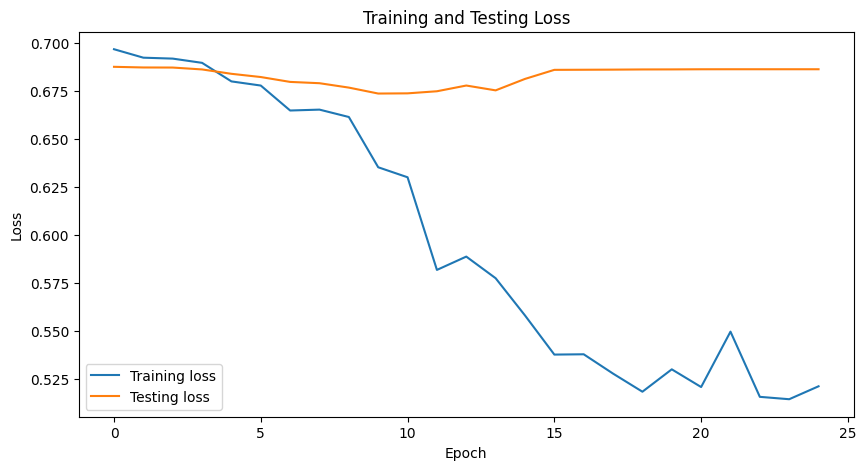

In [72]:
# Plot the training and test loss
plt.plot(train_loss_history, label='Training loss')
plt.plot(test_loss_history, label='Testing loss')
plt.legend()
# fix the size of the plot
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [73]:
model.eval()

SimpleNN(
  (layer1): Linear(in_features=29, out_features=16, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=16, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=1, bias=True)
)

## Result

In [74]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = (y_pred >= 0.5).float()  # Convert to binary predictions

# Print the classification report
print(classification_report(y_test_tensor, y_pred))

# Print the confusion matrix
print(confusion_matrix(y_test_tensor, y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.42      0.53        19
         1.0       0.65      0.87      0.74        23

    accuracy                           0.67        42
   macro avg       0.69      0.65      0.64        42
weighted avg       0.68      0.67      0.65        42

[[ 8 11]
 [ 3 20]]


| Model               | Accuracy | Precision for Class 0 | Recall for Class 0 | F1-score |
|--------------------|---------|----------------------|--------------------|-----------|
| Decision Tree       | 0.75    | 0.73                  | 0.83                | 0.74      |
| RandomForest        | 0.76    | 0.75                  | 0.84                | 0.75      |
| SVM                 | 0.72    | 0.76                  | 0.69                | 0.72      |
| KNN                 | 0.72    | 0.74                  | 0.76                | 0.72      |
| LogisticRegression | 0.75    | 0.76                  | 0.70                | 0.80      |
| LightGBM            | 0.74    | 0.76                  | 0.76                | 0.74      |
| MLP                 | 0.76    | 0.77                  | 0.81                | 0.76      |


## lift chart for the best model - random forest

In [293]:
import kds

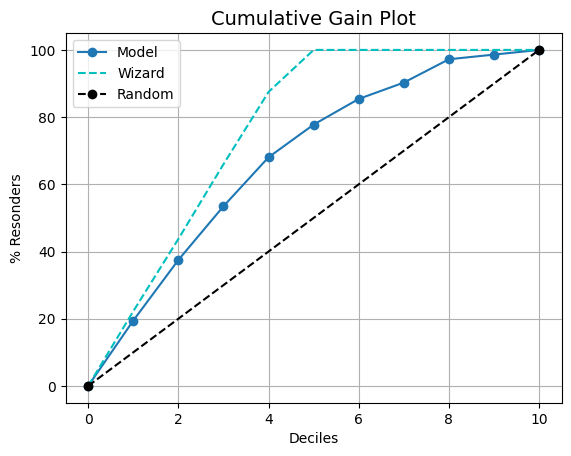

In [297]:
rf = RandomForestClassifier(**study_rf.best_params)
rf.fit(X_train, y_train.squeeze())
y_prob = rf.predict_proba(X_test)
kds.metrics.plot_cumulative_gain(y_test.squeeze(), y_prob[:,1])
plt.show()

## ROC curve for the best model - random forest

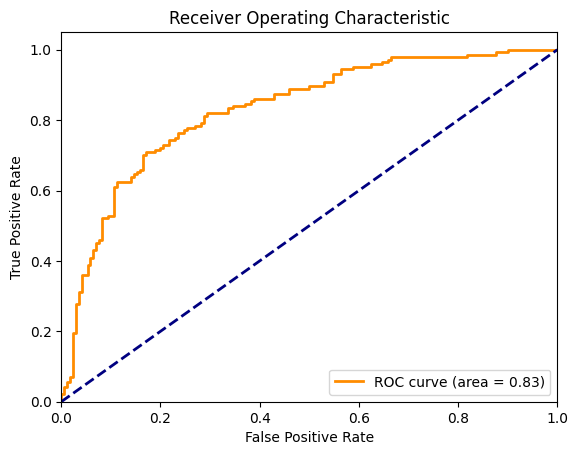

In [301]:
# print out the roc curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])  
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Save all the models

In [303]:
# save all the models
import joblib
joblib.dump(study_dt, 'Models/study_dt.pkl')
joblib.dump(study_rf, 'Models/study_rf.pkl')
joblib.dump(study_svm, 'Models/study_svm.pkl')
joblib.dump(study_knn, 'Models/study_knn.pkl')
joblib.dump(study_lr, 'Models/study_lr.pkl')
joblib.dump(auto_best_lgb, 'Models/auto_best_lgb.pkl')
torch.save(model.state_dict(), 'Models/model_nn_state_dict.pth')
